-------pre-process data start-------
訓練集筆數: 60000
測試集筆數: 10000
train_dataset[0] - 影像張量形狀: torch.Size([1, 28, 28])
train_dataset[0] - 標籤: 9
批次影像張量形狀: torch.Size([64, 1, 28, 28])
批次標籤: tensor([6, 0, 7, 1, 4, 6, 8, 5, 2, 1])
測試集 - 批次影像張量形狀: torch.Size([64, 1, 28, 28])
測試集 - 批次標籤: tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])


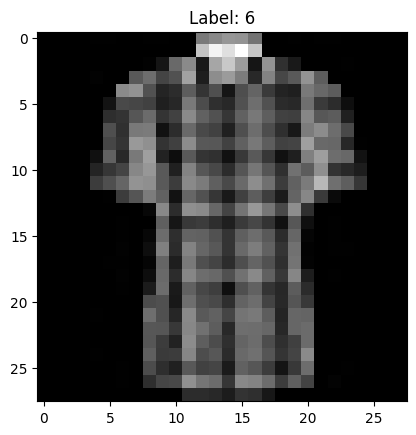

-------pre-process data end-------


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


print("-------pre-process data start-------")

# 1. 定義資料轉換
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 2. 載入資料集
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform
)
test_dataset = torchvision.datasets.FashionMNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform
)

# 3. 建立 DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 印出 train_dataset 與 test_dataset 的大小
print(f"訓練集筆數: {len(train_dataset)}")
print(f"測試集筆數: {len(test_dataset)}")

# 顯示 tensor 形狀及 label
image0, label0 = train_dataset[0]
print("train_dataset[0] - 影像張量形狀:", image0.shape)
print("train_dataset[0] - 標籤:", label0)

# 從 train_loader、 test_loader取出一個 batch，打印形狀與標籤
data_iter = iter(train_loader)
images, labels = next(data_iter)
print("批次影像張量形狀:", images.shape) 
print("批次標籤:", labels[:10])

test_data_iter = iter(test_loader)
test_images, test_labels = next(test_data_iter)
print("測試集 - 批次影像張量形狀:", test_images.shape)
print("測試集 - 批次標籤:", test_labels[:10])

# 顯示一張圖片
plt.imshow(images[0].squeeze().numpy(), cmap='gray')
plt.title(f"Label: {labels[0].item()}")
plt.show()
print("-------pre-process data end-------")

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ====================================================
# (1) Mixup 資料增強 
# ====================================================
def mixup_data(x, y, alpha=1.0, device='cuda'):

    if alpha <= 0:
        return x, y, 1.0

    # 取樣 lambda
    lam = torch.distributions.Beta(alpha, alpha).sample().to(device)

    batch_size = x.size(0)
    # 隨機打亂索引
    index = torch.randperm(batch_size).to(device)

    # Mixup
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]

    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    # 計算 Mixup Loss
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


# ====================================================
# (2) 定義簡易殘差模組 (Residual Block) + GroupNorm
# ====================================================
class BasicResidualBlock(nn.Module):
    """
    簡化版本的殘差模組:
    1. Conv -> GN -> ReLU
    2. Conv -> GN
    最後將輸入加回輸出，然後再 ReLU
    """
    def __init__(self, in_channels, out_channels, stride=1, groups=8):
        super(BasicResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels,
                               kernel_size=3, stride=stride, padding=1)
        self.gn1 = nn.GroupNorm(groups, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, stride=1, padding=1)
        self.gn2 = nn.GroupNorm(groups, out_channels)

        # 若維度不同，需要投影 (project) 使殘差分支與主幹分支對齊
        # 例如 in_channels=64, out_channels=128, stride=2 時
        self.shortcut = None
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels,
                          kernel_size=1, stride=stride),
                nn.GroupNorm(groups, out_channels)
            )

    def forward(self, x):
        residual = x

        # 主路徑
        out = F.relu(self.gn1(self.conv1(x)))
        out = self.gn2(self.conv2(out))

        # 殘差分支: 若尺寸不合要投影
        if self.shortcut is not None:
            residual = self.shortcut(x)

        # 將殘差加回
        out += residual
        out = F.relu(out)

        return out

# ====================================================
# (3) 定義 CNN 模型 
# ====================================================
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # ------------------------------------------------
        # 先疊幾層卷積 + GroupNorm
        # ------------------------------------------------
        # 第一層卷積: 輸出通道=32
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1, stride=1)
        self.gn1   = nn.GroupNorm(8, 32)

        # ------------------------------------------------
        # 插入殘差模組: in_channels=32 -> out_channels=64, stride=2
        # => 影像空間尺寸將縮小一半
        # ------------------------------------------------
        self.block1 = BasicResidualBlock(in_channels=32, out_channels=64, stride=2, groups=8)

        # ------------------------------------------------
        # 再插入殘差模組: 64 -> 128, stride=2
        # ------------------------------------------------
        self.block2 = BasicResidualBlock(in_channels=64, out_channels=128, stride=2, groups=8)

        # ------------------------------------------------
        # 卷積後的 Dropout
        # ------------------------------------------------
        self.dropout_conv = nn.Dropout(p=0.3)

        # ------------------------------------------------
        # 全連接層
        # ------------------------------------------------
        self.fc1 = nn.Linear(128 * 7 * 7, 256)
        self.dropout_fc = nn.Dropout(p=0.4)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # 前面先來一層卷積 + GN + ReLU
        x = F.relu(self.gn1(self.conv1(x)))
        
        # 經過殘差 block 1
        x = self.block1(x)

        # 經過殘差 block 2
        x = self.block2(x)

        # dropout
        x = self.dropout_conv(x)

        # flatten
        x = x.view(x.size(0), -1)

        # 全連接
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

if __name__ == "__main__":
    print("-------CNN model start-------")
    # 建立一個 CNN 模型
    model = CNN()

    print("-------CNN model end-------")


-------CNN model start-------
最終輸出 output 的維度: torch.Size([4, 10])
最終輸出 output 的資料型態: torch.float32
-------CNN model end-------


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim


# --------------------------
# 1. 檢查並設定GPU
# --------------------------
print("-------device start-------")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print("偵測到 GPU，可使用 CUDA 加速運算。")
else:
    print("未偵測到 GPU，使用 CPU 進行運算。")

# --------------------------
# 2. 建立並移動模型到GPU
# --------------------------
model = CNN().to(device)
print("\n--- 模型資訊 ---")
print("模型的資料型態:", next(model.parameters()).dtype)  # 取得模型內任一參數並查看資料型態
print("模型結構如下：")
print(model)

# --------------------------
# 3. 定義損失函式
# --------------------------
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
print("\n--- 損失函式資訊 ---")
print("使用的損失函式:", criterion)

# --------------------------
# 4. 定義優化器
# --------------------------
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)
print("\n--- 優化器資訊 ---")
print("使用的優化器:", optimizer)
print("優化器內部的設定參數:", optimizer.defaults)

scheduler = optim.lr_scheduler.CyclicLR(
    optimizer,
    base_lr=1e-4,
    max_lr=1e-3,
    step_size_up=100,   
    mode='triangular2',
    cycle_momentum=False  # AdamW 預設就不建議用 momentum
)

for param_group in optimizer.param_groups:
    print("此參數組的學習率 (lr):", param_group['lr'])
    break
print("-------device end-------")


-------device start-------
偵測到 GPU，可使用 CUDA 加速運算。

--- 模型資訊 ---
模型的資料型態: torch.float32
模型結構如下：
CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (gn1): GroupNorm(8, 32, eps=1e-05, affine=True)
  (block1): BasicResidualBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (gn1): GroupNorm(8, 64, eps=1e-05, affine=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (gn2): GroupNorm(8, 64, eps=1e-05, affine=True)
    (shortcut): Sequential(
      (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
      (1): GroupNorm(8, 64, eps=1e-05, affine=True)
    )
  )
  (block2): BasicResidualBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (gn1): GroupNorm(8, 128, eps=1e-05, affine=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (gn2): GroupNorm(8, 128, eps=1e-05, affine=True)
    (shortcut): Sequential(
  

Epoch 1/10: 100%|██████████| 938/938 [00:14<00:00, 65.58it/s]


Epoch [1/10] Train Loss: 0.5585, Train Acc: 99.90%, Test Loss: 0.6716, Test Acc: 93.13%


Epoch 2/10: 100%|██████████| 938/938 [00:14<00:00, 64.68it/s]


Epoch [2/10] Train Loss: 0.5558, Train Acc: 99.92%, Test Loss: 0.6692, Test Acc: 93.24%


Epoch 3/10: 100%|██████████| 938/938 [00:15<00:00, 62.43it/s]


Epoch [3/10] Train Loss: 0.5522, Train Acc: 99.96%, Test Loss: 0.6733, Test Acc: 93.23%


Epoch 4/10: 100%|██████████| 938/938 [00:14<00:00, 62.81it/s]


Epoch [4/10] Train Loss: 0.5504, Train Acc: 99.96%, Test Loss: 0.6710, Test Acc: 93.05%


Epoch 5/10: 100%|██████████| 938/938 [00:13<00:00, 67.18it/s]


Epoch [5/10] Train Loss: 0.5475, Train Acc: 99.98%, Test Loss: 0.6714, Test Acc: 93.28%


Epoch 6/10: 100%|██████████| 938/938 [00:14<00:00, 66.81it/s]


Epoch [6/10] Train Loss: 0.5463, Train Acc: 99.97%, Test Loss: 0.6672, Test Acc: 93.15%


Epoch 7/10: 100%|██████████| 938/938 [00:14<00:00, 66.00it/s]


Epoch [7/10] Train Loss: 0.5445, Train Acc: 99.97%, Test Loss: 0.6736, Test Acc: 93.17%


Epoch 8/10: 100%|██████████| 938/938 [00:14<00:00, 66.11it/s]


Epoch [8/10] Train Loss: 0.5433, Train Acc: 99.99%, Test Loss: 0.6736, Test Acc: 93.03%


Epoch 9/10: 100%|██████████| 938/938 [00:13<00:00, 68.17it/s]


Epoch [9/10] Train Loss: 0.5414, Train Acc: 99.99%, Test Loss: 0.6710, Test Acc: 93.05%


Epoch 10/10: 100%|██████████| 938/938 [00:14<00:00, 66.87it/s]


Epoch [10/10] Train Loss: 0.5404, Train Acc: 99.98%, Test Loss: 0.6690, Test Acc: 93.27%

----- Final Evaluation on Test Set -----
Test Accuracy: 93.27%
Test Loss: 0.6690


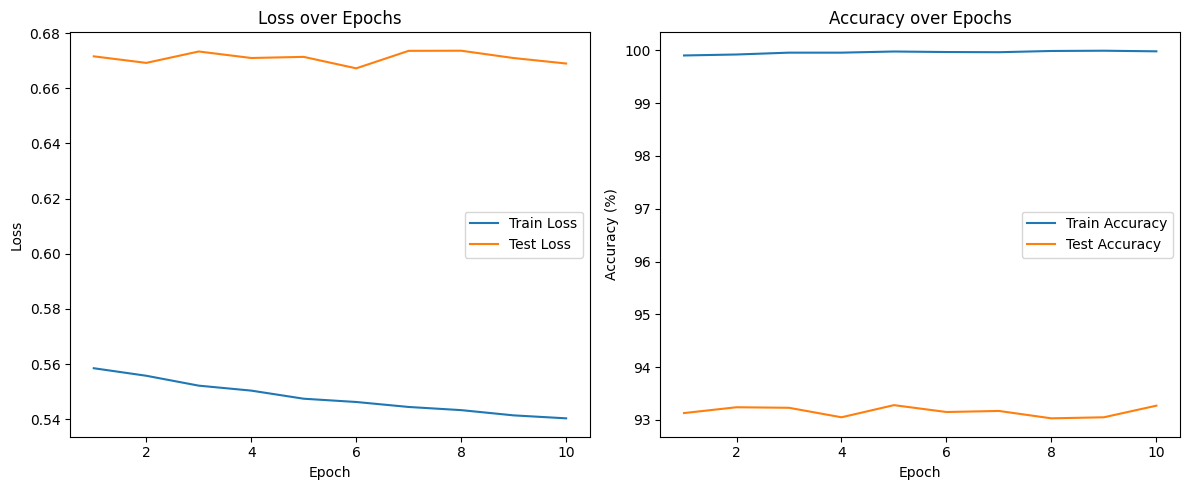

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torch.nn import functional as F

# --------------------------------------------------
# 函數：計算 Accuracy
# --------------------------------------------------
def calculate_accuracy(model, data_loader, device):
    model.eval()  # 設置模型為推論模式
    correct = 0
    total = 0
    with torch.no_grad():  # 推論時不需要梯度
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100.0 * correct / total
    return accuracy

# --------------------------------------------------
# 函數：計算 Loss
# --------------------------------------------------
def calculate_loss(model, data_loader, criterion, device):
    model.eval()  # 設置模型為推論模式
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

    average_loss = total_loss / len(data_loader)
    return average_loss

num_epochs = 10

# 創建四個 list 來儲存不同階段的 loss 與 accuracy
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    # ------------------------
    # (1) 模型訓練階段
    # ------------------------
    model.train()  # 設置模型為訓練模式
    running_loss = 0.0
    
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()           # 清空梯度
        outputs = model(images)         # 前向傳播
        loss = criterion(outputs, labels)
        loss.backward()                 # 反向傳播
        optimizer.step()                # 更新參數

        running_loss += loss.item()
        optimizer.zero_grad()


        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        scheduler.step()

    # 計算單個 epoch 的平均 loss
    epoch_train_loss = running_loss / len(train_loader)

    # ------------------------
    # (2) 訓練集、測試集上做評估
    # ------------------------
    epoch_train_acc = calculate_accuracy(model, train_loader, device)
    epoch_test_acc = calculate_accuracy(model, test_loader, device)
    epoch_test_loss = calculate_loss(model, test_loader, criterion, device)

    # ------------------------
    # (3) 紀錄當前 epoch 的結果
    # ------------------------
    train_losses.append(epoch_train_loss)
    test_losses.append(epoch_test_loss)
    train_accuracies.append(epoch_train_acc)
    test_accuracies.append(epoch_test_acc)

    # ------------------------
    # (4) 印出當前 epoch 的訓練指標
    # ------------------------
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_train_loss:.4f}, "
          f"Train Acc: {epoch_train_acc:.2f}%, "
          f"Test Loss: {epoch_test_loss:.4f}, "
          f"Test Acc: {epoch_test_acc:.2f}%")

# --------------------------------------------------
# (5) 最終訓練結束後，可再列一次最終結果
# --------------------------------------------------
print("\n----- Final Evaluation on Test Set -----")
final_test_acc = calculate_accuracy(model, test_loader, device)
final_test_loss = calculate_loss(model, test_loader, criterion, device)
print(f"Test Accuracy: {final_test_acc:.2f}%")
print(f"Test Loss: {final_test_loss:.4f}")

# --------------------------------------------------
# (6) 圖表化：Loss 和 Accuracy
# --------------------------------------------------
epochs_range = range(1, num_epochs + 1)

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, test_losses, label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, test_accuracies, label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()



--- 測試模型成效 ---
批次影像數量: 64
顯示前 4 張測試影像，並比對真實標籤與模型預測：


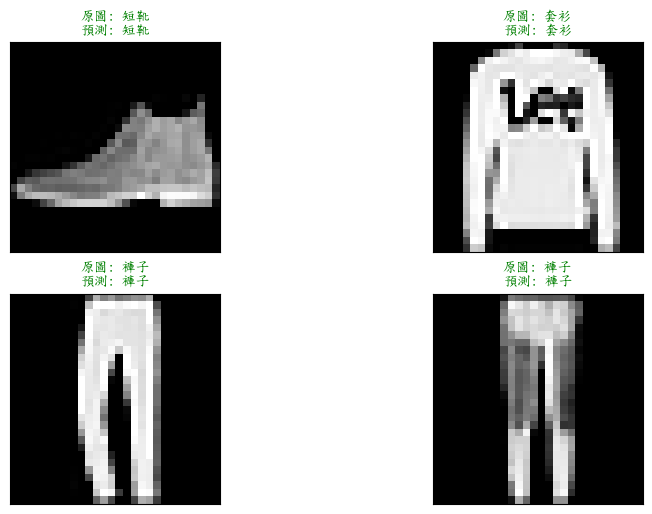

In [10]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties

# 定義 10 個服裝類別的中文名稱
class_names = ['T恤', '褲子', '套衫', '洋裝', '外套', 
               '凉鞋', '襯衫', '運動鞋', '包包', '短靴']

def imshow(img):
    """
    功能：將輸入影像 img (Tensor) 反標準化後，以 matplotlib 顯示。
    """
    # 反標準化 (假設 Normalize 使用了 mean=0.5, std=0.5)
    img = img / 2 + 0.5
    npimg = img.numpy()
    # 轉置維度從 [C, H, W] -> [H, W, C]，並顯示灰階圖片
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

def visualize_model_predictions(model, test_loader, class_names, device):
    """
    功能：從 test_loader 取出一個批次的測試影像，並顯示模型的預測結果。
    """
    font = FontProperties(fname="C:/Windows/Fonts/kaiu.ttf")

    # 切換模型為推論模式
    model.eval()

    # 從 test_loader 取得一個批次的資料
    dataiter = iter(test_loader)
    images, labels = next(dataiter)  # 取出 batch
    # 將資料及標籤移動到GPU
    images, labels = images.to(device), labels.to(device)

    # 前向傳播，取得模型輸出
    outputs = model(images)
    # 取得預測標籤
    _, predicted = torch.max(outputs, 1)

    print("\n--- 測試模型成效 ---")
    print(f"批次影像數量: {images.size(0)}")
    print("顯示前 4 張測試影像，並比對真實標籤與模型預測：")

    # 顯示前 4 張圖片及其預測結果
    fig = plt.figure(figsize=(10, 6))
    for idx in range(4):
        ax = fig.add_subplot(2, 2, idx + 1, xticks=[], yticks=[])
        # 需先把圖片移回 CPU，再做反標準化
        img = images[idx].cpu()
        img = img / 2 + 0.5  # 反標準化
        npimg = img.numpy()

        plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
        true_label = class_names[labels[idx]]
        pred_label = class_names[predicted[idx]]

        # 若預測正確顯示綠色標題，否則顯示紅色
        color_setting = 'green' if predicted[idx] == labels[idx] else 'red'
        ax.set_title(f'原圖: {true_label}\n預測: {pred_label}',
                     fontproperties=font, color=color_setting)

    plt.show()

visualize_model_predictions(model, test_loader, class_names, device)
